
# Analysis Notebook

**Author**: Ruben Millan-Solsona  
**Date**: 2024-11-10 

This notebook contains functions to prepare and flatten images for stitching in AFM analysis, using both automatic and manual methods. It includes tools for saving and normalizing images for further analysis.  
**Sections**:
1. **Import Statements and Setup**: Required modules and classes.
2. **Auto-Flatting for Stitch Preparation**: Automatically flattens images and generates masks using threshold-based adjustments.
3. **Manual Plane Subtraction for Stitch Preparation**: Manually flattens images by selecting global planes using defined points.
4. **Execution Example**: An example execution of the manual plane subtraction function.


## Stitching ##

### Image Stitching Analysis

This notebook demonstrates two methods for image stitching: one based on coordinate alignment and another using the `Stitch2D` library, which leverages feature-based alignment. The goal is to create a seamless composite image from a set of individual image tiles, useful for applications requiring a larger field of view, such as microscopy or aerial photography.

The results of each stitching method will be saved in a dedicated folder named `out_stitching`, created within the main data folder. This allows easy access to both the original data and the stitched outputs for further analysis or visualization.

- **Coordinate-Based Stitching:** This method relies on known positional information of each tile, ensuring that each image is placed at its correct location within the larger grid. It is particularly effective when precise coordinates are available and when error position is minimal.
  
- **Feature-Based Stitching (Stitch2D Library):** Using the `Stitch2D` library, this approach identifies and matches distinctive features between overlapping tiles, adjusting their placement to create a coherent whole. This method is highly adaptable to slight positional shifts or rotational differences between images, making it ideal for cases where precise coordinates are unavailable.

The notebook provides a side-by-side comparison of the results from each method, allowing you to assess the relative effectiveness and quality of the final stitched image in both cases. 



In [1]:
import bachproces as bach

Directory = 'DataTest'      #Your directory
#This function prepares GWY images for stitching. In the same directory where the RAW files are stored, an `out*` 
# folder is created, containing the processed images. 
flattened_images, masks, out_folder = bach.PrepareStichByAutoFlattenPlus(Directory =Directory, Exttype = '.gwy', perc = 0.4, nstd =4 )


In [2]:
import stitching_v2 as stit

#out_folder = r'DataTest\Out_Flatten_2025_02_03_14_44_03'
#Stitch2D Method
stitched_image = stit.SimpleStitch2dMethod(PathPNGFiles = out_folder,dimX = 4, downsample = 1,limit = None, from_placed = False)

#Simple Coordinate Method
stitched_image = stit.SimpleCoordinateMethod(PathXYZFiles = out_folder,filas =2,columnas =4,nstd = 4)


c:\Users\z78\Documents\Projects\AutomatedAFM_Biofilmformation\Repositorio\Analysis-Large-Area-AFM\DataTest\Out_Flatten_2025_02_06_11_07_37\out_stitching_2D


## Segmentation ##

### Bacteria Segmentation and Feature Mapping

With the stitched image complete, the next step is to perform segmentation to identify individual bacteria within the image. This process uses a pre-trained YOLO model, which is well-suited for detecting and segmenting distinct objects within complex images. The segmentation results enable the creation of detailed feature maps, providing insights into various bacterial characteristics such as orientation, eccentricity, area, and density.

The large volume of data generated during segmentation and analysis is managed using `.h5` files, which facilitate efficient memory handling and fast access to segmented regions. This data structure is particularly useful for handling high-resolution images or extensive datasets without running into memory limitations.

By the end of this section, the notebook provides not only a segmented image but also comprehensive bacterial feature maps, supporting deeper analysis and quantitative assessments of bacterial distribution and morphology across the entire stitched image.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_v3 as seg
from ultralytics import YOLO
import segmentation_v3 as seg
import os
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap

c:\Users\z78\Documents\Projects\AutomatedAFM_Biofilmformation\Repositorio\Analysis-Large-Area-AFM\myvenv\Lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)



0: 640x640 37 0s, 263 bacterias, 156.2ms
Speed: 0.0ms preprocess, 156.2ms inference, 214.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 17 0s, 239 bacterias, 130.1ms
Speed: 0.0ms preprocess, 130.1ms inference, 156.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 45 0s, 222 bacterias, 82.6ms
Speed: 0.0ms preprocess, 82.6ms inference, 166.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 10 0s, 230 bacterias, 167.1ms
Speed: 0.0ms preprocess, 167.1ms inference, 138.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 48 0s, 252 bacterias, 93.7ms
Speed: 0.0ms preprocess, 93.7ms inference, 186.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 93 0s, 204 bacterias, 92.7ms
Speed: 0.0ms preprocess, 92.7ms inference, 202.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 100 bacterias, 173.4ms
Speed: 0.0ms preprocess, 173.4ms inference, 107.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 32 0s, 

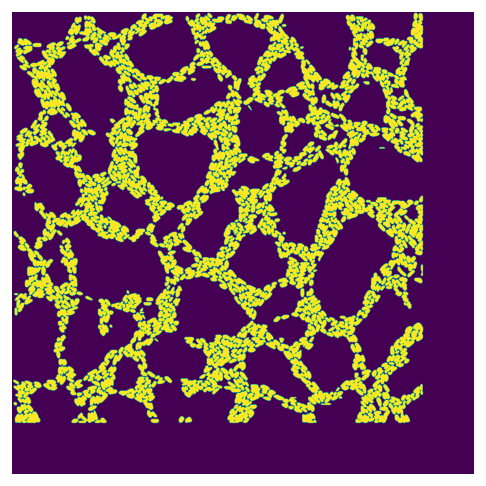

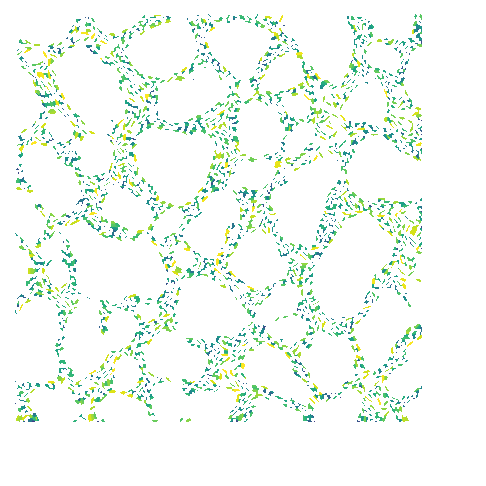

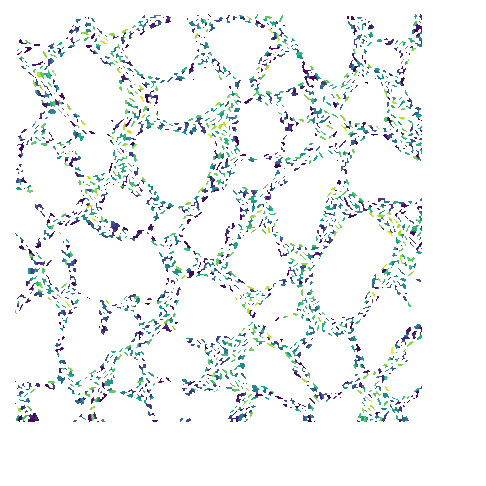

In [5]:
# Directory and name of the image file to segment
file_name = 'flatten_Pantoea_1.png'
directori =out_folder
image_path = os.path.join(directori, file_name)

# Paths to save h5 and parameter files
# Extract the name without extension and the original extension
shortName, _ = os.path.splitext(file_name)
# Get the current date and time in the desired format, including seconds
fecha_actual = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Create the new file name with the tag and new extension
prediction_h5 = f"{'Prediction_'}{shortName}{fecha_actual}{'.h5'}"
prediction_nms_h5 = f"{'Prediction_nms_'}{shortName}{fecha_actual}{'.h5'}"
parameters_txt = f"{'Parameters_'}{shortName}{fecha_actual}{'.txt'}"
# Load a large image (example image)
# Load the image with OpenCV (in BGR format)
image_BGR = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2RGB)
# Convert grayscale to RGB by duplicating the grayscale channel across three channels
# image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_GRAY2RGB)
image_rgb = image_rgb.astype(np.float32)
# Check if values are between 0 and 255; if so, normalize to [0, 1]
if np.max(image_rgb) > 1:
    image_normalized = image_rgb / 255.0  # Normalize to [0, 1]
else:
    image_normalized = image_rgb  # Already normalized

height, width = image_normalized.shape[:2]

np1 = max(height, width)      # Maximum number of pixels in the image
lt = 14.3   # micrometers      # Size of the training image
l1 = 81.0810811                 # Size of the input image um
npx = int(np1 * lt / l1)      # Pixels used to crop the image
patch_size = 640              # Patch size suitable for YOLO
scale = patch_size / npx      # Scale to resize images
overlap = 0.10  # Overlap size between patches as a percentage

# List of images
# image_normalized = exposure.equalize_hist(image_normalized)
lista_imagenes, lista_pos, n_cuadros_x, n_cuadros_y, new_height, new_width = seg.dividir_imagen_en_cuadrados_con_solapamiento(image_normalized, npx, solapamiento=overlap)
# seg.mostrar_subimagenes(lista_imagenes, n_cuadros_x, n_cuadros_y)

model = YOLO('best_final.pt')  # Replace with the correct path to your best.pt file

# Predict the list
boxes_list, scores_list, pos_list = seg.PredictImagesList(prediction_h5, lista_imagenes,
                                     lista_pos, scale, model, sigma=8, above_area_threshold=3000, below_area_threshold=550, conf=0.02, equalize=True, is_INTER_LANCZOS4=True)

#apply nms
boxes, scores, pos = seg.apply_nms_list(prediction_h5, prediction_nms_h5, boxes_list, scores_list, pos_list, iou_threshold=0.4)
#combine masks
g_mask = seg.combinar_mascaras_en_imagen(prediction_nms_h5, pos, round(new_height * scale) + 1, round(new_width * scale) + 1)
seg.show_image(g_mask)

#make properties and maps file
Maps = seg.DoPropertyMapAndTXT(prediction_nms_h5, parameters_txt, round(new_height * scale) + 1, round(new_width * scale) + 1)

#show maps
seg.show_image(Maps['Area'])
seg.show_image(Maps['Score'])


### Visualization map

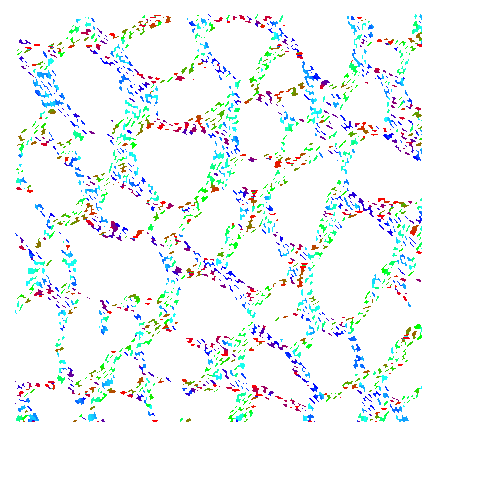

In [6]:

# Crear el colormap personalizado (rojo -> azul -> gris claro -> verde -> rojo)
colors = [(1, 0, 0),   # Rojo para el mínimo
            (0, 1, 0),   # Azul para los valores bajos intermedios
            (0.1, 1, 1),  # Gris claro para el cero
            (0, 0, 1),   # Verde para los valores altos intermedios
            (1, 0, 0)]   # Rojo para el máximo


cmap_custom = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Crear un colormap modificado para mostrar NaN (píxeles no segmentados) en blanco
cmap_custom.set_bad(color="white")

plt.figure(figsize=(5, 5), dpi=120)  # Ajusta el tamaño de la ventana de la imagen si es necesario

# Selecciona un trozo de la matriz, por ejemplo, una sección de 1000x1000 píxeles
sub_matrix = Maps['Orientation'][:, :]

# Muestra solo el trozo seleccionado
plt.imshow(sub_matrix, vmin=-3.1416/2, vmax=3.1416/2, cmap=cmap_custom)

# Añadir la barra de color a la derecha
#plt.colorbar(img)  # Mostrar la barra de color
plt.axis('off')  # Quitar los ejes
plt.show()


### Flagella Visualization

In this section, the notebook processes flattened XYZ files within a given folder to visualize flagella regions within the images. The workflow includes:

1. **Loading Flattened XYZ Files:** Reads all flattened XYZ files from a specified folder, providing the data necessary for individual flagella analysis.
  
2. **Creating a Flagella Mask:** Generates a mask to isolate regions containing flagella, helping to focus on areas of interest.

3. **Cropping and Flattening Individual Regions:** Each flagged region is cropped and undergoes individual flattening, ensuring a consistent visual representation across all regions.

4. **Reconstructing and Saving the Flattened Image:** The cropped and flattened regions are then combined to form a single image, which is saved in PNG format with an appropriate color scale.

5. **Stitching Flagella Images and Generating Statistics:** Following image reconstruction, flagella images are stitched together, and a summary text file is generated. This file includes comprehensive statistics on each segmented region, aiding in quantitative analysis.

This section provides not only the visualized flagella image but also detailed statistical insights into the detected regions, supporting further study of flagella morphology and distribution.

In [8]:
import os
import copy
from typing import List, Tuple
from AFMclasses import clImage, ChannelType, ExtentionType
import managefiles as mgf
import flattening_v2 as fla
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label, find_objects

# Load image
path = out_folder   #r'DataTest\your directory '

Areas_filename = 'Areas.txt'
higth_filename = 'higth.txt'

umbral = 150e-9

# Output folder
outfolder = mgf.DoFolderWithDate('flagella',path)


# Load images
ImgList = mgf.LoadAllImageFile_fromDirectory(Directory=path, Exttype='.xyz')

# Open the file once for all regions
out_higth_file = os.path.join(outfolder, higth_filename)
with open(out_higth_file, 'w') as higthfile:
    output_file = os.path.join(outfolder, Areas_filename)
    with open(output_file, 'w') as areafile:
        # File header
        areafile.write("index\tregion\tx_min\ty_min\tx_max\ty_max\tregion_area\tflagella_area\n")
        
        # Iterate over each image
        for index, Img in enumerate(ImgList):
            # Display image
            #mgf.DisplayImage_with_scale(Img)
            
            # Make a copy
            copi_img = copy.deepcopy(Img)
            
            # Create mask with threshold
            mask = fla.MakeMaskWithThreshold(Img.matriz, umbral, area_minima=550, show=0)
            
            # Apply dilation and erosion
            structuring_element = disk(6)
            dilated_mask = binary_dilation(mask, structure=structuring_element)
            dilated_mask = binary_erosion(dilated_mask, structure=structuring_element)

            image = Img.matriz
            output_flattened_image = np.zeros_like(image)  # Output matrix to store flattened regions
            
            # Detect connected regions in the mask
            labeled_mask, num_features = label(dilated_mask)
            regions = find_objects(labeled_mask)  # Get bounding boxes for each region
            
            # Crop and process each region
            for i, bbox in enumerate(regions, start=1):
                if bbox is not None:
                    y_min, y_max = bbox[0].start, bbox[0].stop
                    x_min, x_max = bbox[1].start, bbox[1].stop

                    # Crop image and mask
                    cropped_image = image[y_min:y_max, x_min:x_max]
                    cropped_mask = (labeled_mask[y_min:y_max, x_min:x_max] == i).astype(int)

                    # Calculate area of the current region
                    region_area = np.sum(cropped_mask)
                    masked_image = cropped_image * cropped_mask

                    # Flatten
                    flatten, _ = fla.FlattenPlus_Mask(masked_image, mask=cropped_mask, perc=60)
                    output_flattened_image[y_min:y_max, x_min:x_max] += flatten

                    # Create flagella mask and calculate flagella area
                    mask_fla = fla.MakeMaskWithThreshold(flatten, 15e-9, area_minima=0, show=0)
                    flagella_area = np.sum(mask_fla == 0)

                    # Save matrices
                    # fla.SaveMatriz(flatten, f'flatten_{index}_{i}.xyz', outfolder)
                    # fla.SaveMatriz(cropped_mask, f'cropped_mask_{index}_{i}.xyz', outfolder)
                    # fla.SaveMatriz(cropped_image, f'cropped_image_{index}_{i}.xyz', outfolder)
                    # fla.SaveMatriz(mask_fla, f'flagella_mask_{index}_{i}.xyz', outfolder)

                    # Write coordinates and heights where mask is 1
                    y_coords, x_coords = np.where(mask_fla == 0)
                    heights = flatten[y_coords, x_coords]
                    for x, y, height in zip(x_coords, y_coords, heights):
                        higthfile.write(f"{x + x_min} {y + y_min} {height}\n")  # Adjust global coordinates
                    
                    # Write image region coordinates and areas
                    areafile.write(f"{index}\t{i}\t{x_min}\t{y_min}\t{x_max}\t{y_max}\t{region_area}\t{flagella_area}\n")
            
            if index == 0:
                Norm = mgf.NormalizeNumpysOrclImages(output_flattened_image, nstd=4)

            pngfile = os.path.splitext(Img.filename)[0]
            mgf.SaveNumpyToPNG_By_PIL(output_flattened_image, outfolder, pngfile, norm=Norm, nstd=4, colormap='copper')
            print('PNG file:', pngfile)
        
            copi_img.matriz = output_flattened_image
            mgf.SaveImageToXYZ(copi_img, filename=f"flagella_{os.path.splitext(Img.filename)[0]}.xyz", path=outfolder)

   

c:\Users\z78\Documents\Projects\AutomatedAFM_Biofilmformation\Repositorio\Analysis-Large-Area-AFM\myvenv\Lib\site-packages\scipy\ndimage\_measurements.py:308: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
c:\Users\z78\Documents\Projects\AutomatedAFM_Biofilmformation\Repositorio\Analysis-Large-Area-AFM\flattening_v2.py:660: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(linear_fit, x_values, y_values, p0=(0, 0))


PNG file: flatten_Pantoea_1
PNG file: flatten_Pantoea_2
PNG file: flatten_Pantoea_3
PNG file: flatten_Pantoea_4
PNG file: flatten_Pantoea_5
PNG file: flatten_Pantoea_6
PNG file: flatten_Pantoea_7
PNG file: flatten_Pantoea_8
